# RNN Time Series of Nike 

Choose your favorite (or any) publicly traded company (other than IBM) to download daily stock prices using Yahoo Finance. Use the closing prices of the past nine days to predict the 10-day closing stock price (note: this is similar to the weather data tutorial. Use RNN, LTSM, Gru, and Conv1D techniques to predict the 10th-day closing price). Discuss the performance of each of the models and which one seems to perform the best.

In this notebook, I will work with the stock price of Nike from 2010 to 2023. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import time

# Common imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2023-04-22 20:11:37.079387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data Preparation

### Read the Dataset

In [2]:
import pandas as pd

nike = pd.read_csv('NKE.csv')

nike.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,16.514999,16.517500,16.280001,16.3375,13.949665,11972400
1,2010-01-05,16.285000,16.447500,16.174999,16.4025,14.005167,6275200
2,2010-01-06,16.350000,16.422501,16.235001,16.3025,13.919781,13399200
3,2010-01-07,16.280001,16.500000,16.262501,16.4625,14.056394,7187600
4,2010-01-08,16.447500,16.462500,16.235001,16.4300,14.028647,7249600


In [3]:
# Convert the temp to Fahrenheit:

nike = nike.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [4]:
nike

,Date,Close
0,2010-01-04,16.337500
1,2010-01-05,16.402500
2,2010-01-06,16.302500
3,2010-01-07,16.462500
4,2010-01-08,16.430000
...,...,...
3340,2023-04-12,123.660004
3341,2023-04-13,126.430000
3342,2023-04-14,125.949997
3343,2023-04-17,126.190002


In [5]:
# Dropping last 5 rows
nike.drop(nike.tail(5).index,inplace = True)

In [6]:
nike

,Date,Close
0,2010-01-04,16.337500
1,2010-01-05,16.402500
2,2010-01-06,16.302500
3,2010-01-07,16.462500
4,2010-01-08,16.430000
...,...,...
3335,2023-04-04,123.690002
3336,2023-04-05,120.900002
3337,2023-04-06,120.220001
3338,2023-04-10,121.910004


In [7]:
days_in_sequence = 10
number_observations = len(nike)/days_in_sequence
number_observations

334.0

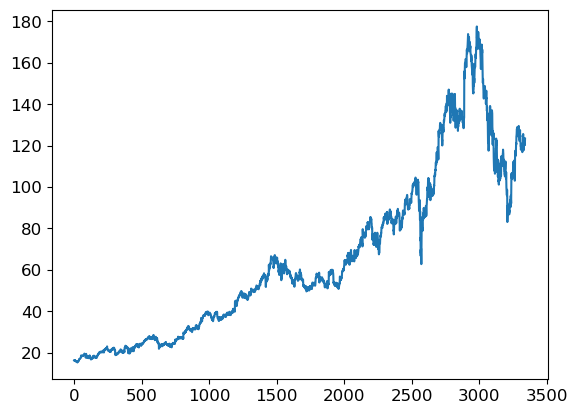

In [8]:
#Plot 

plt.plot(nike['Close'])
plt.show()

### RESHAPE the data set

In [9]:
nike.shape

(3340, 2)

In [10]:
# Re-organize the data set by 10-day batches

temp = np.array(nike['Close']).reshape(int(number_observations),days_in_sequence)

temp

array([[ 16.3375  ,  16.4025  ,  16.3025  , ...,  16.35    ,  16.247499,
         16.0975  ],
       [ 16.1775  ,  16.045   ,  15.91    , ...,  15.88    ,  15.9375  ,
         16.025   ],
       [ 15.9825  ,  16.      ,  15.5225  , ...,  15.7375  ,  15.6225  ,
         15.9125  ],
       ...,
       [118.790001, 118.580002, 119.580002, ..., 117.870003, 117.489998,
        116.860001],
       [119.      , 118.169998, 120.650002, ..., 120.970001, 120.709999,
        117.809998],
       [117.870003, 120.489998, 120.099998, ..., 120.220001, 121.910004,
        123.300003]])

In [11]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,days_in_sequence,1))

temp_df

,0,1,2,3,4,5,6,7,8,9
0,16.337500,16.402500,16.302500,16.462500,16.430000,16.227501,16.205000,16.350000,16.247499,16.097500
1,16.177500,16.045000,15.910000,15.745000,15.917500,15.935000,16.000000,15.880000,15.937500,16.025000
2,15.982500,16.000000,15.522500,15.425000,15.325000,15.627500,15.660000,15.737500,15.622500,15.912500
3,16.120001,16.110001,16.087500,16.077499,16.032499,16.232500,16.540001,16.900000,17.059999,17.007500
4,16.910000,16.907499,17.080000,17.205000,17.232500,17.280001,17.437500,17.475000,17.597500,17.594999
...,...,...,...,...,...,...,...,...,...,...
329,126.370003,127.330002,129.500000,129.059998,127.610001,125.730003,125.330002,122.910004,122.180000,122.230003
330,125.150002,126.199997,127.480003,124.379997,124.839996,121.099998,119.900002,119.959999,118.040001,118.529999
331,118.790001,118.580002,119.580002,120.940002,120.169998,119.589996,119.860001,117.870003,117.489998,116.860001
332,119.000000,118.169998,120.650002,120.389999,121.199997,125.610001,119.500000,120.970001,120.709999,117.809998


### Reshape for Standardizing Data

In [12]:
temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(3340, 1)

In [13]:
temp_1feature

array([[ 16.3375  ],
       [ 16.4025  ],
       [ 16.3025  ],
       ...,
       [120.220001],
       [121.910004],
       [123.300003]])

### Standardize the values

In [14]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

### Reshape the data back to 10-days format

In [15]:
temp_reshaped = temp_std.reshape(int(number_observations), days_in_sequence)

temp_reshaped.shape

(334, 10)

In [16]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,days_in_sequence,1))

,0,1,2,3,4,5,6,7,8,9
0,-1.220209,-1.218604,-1.221074,-1.217121,-1.217924,-1.222927,-1.223482,-1.219901,-1.222433,-1.226138
1,-1.224162,-1.227435,-1.230770,-1.234846,-1.230585,-1.230152,-1.228547,-1.231511,-1.230090,-1.227929
2,-1.228979,-1.228547,-1.240342,-1.242751,-1.245221,-1.237748,-1.236946,-1.235031,-1.237872,-1.230708
3,-1.225582,-1.225829,-1.226385,-1.226632,-1.227744,-1.222803,-1.215207,-1.206314,-1.202362,-1.203658
4,-1.206067,-1.206129,-1.201867,-1.198780,-1.198100,-1.196927,-1.193036,-1.192110,-1.189084,-1.189146
...,...,...,...,...,...,...,...,...,...,...
329,1.497907,1.521622,1.575227,1.564357,1.528538,1.482097,1.472216,1.412435,1.394402,1.395637
330,1.467769,1.493707,1.525327,1.448748,1.460111,1.367723,1.338079,1.339562,1.292132,1.304236
331,1.310659,1.305472,1.330175,1.363770,1.344749,1.330421,1.337091,1.287933,1.278545,1.262983
332,1.315847,1.295343,1.356607,1.350184,1.370193,1.479133,1.328198,1.364511,1.358089,1.286450


## 2. Split the Data not randomly


In [17]:
split_point = int(len(temp_reshaped)*0.7)
train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [18]:
print(train.shape)
print(test.shape)

(233, 10)
(101, 10)


### Create Input and Target values

Target: 10th day. Input: 9 prior days.

In [19]:
# The first 23 columns (from 0 to 22) are inputs

train_X = train[:, :-1]
train_y = train[:, -1]

pd.DataFrame(train_X)

,0,1,2,3,4,5,6,7,8
0,-1.220209,-1.218604,-1.221074,-1.217121,-1.217924,-1.222927,-1.223482,-1.219901,-1.222433
1,-1.224162,-1.227435,-1.230770,-1.234846,-1.230585,-1.230152,-1.228547,-1.231511,-1.230090
2,-1.228979,-1.228547,-1.240342,-1.242751,-1.245221,-1.237748,-1.236946,-1.235031,-1.237872
3,-1.225582,-1.225829,-1.226385,-1.226632,-1.227744,-1.222803,-1.215207,-1.206314,-1.202362
4,-1.206067,-1.206129,-1.201867,-1.198780,-1.198100,-1.196927,-1.193036,-1.192110,-1.189084
...,...,...,...,...,...,...,...,...,...
228,0.367505,0.360341,0.357870,0.384055,0.398877,0.389737,0.401594,0.423086,0.419380
229,0.410734,0.443342,0.468786,0.485831,0.468045,0.485337,0.465328,0.471997,0.450012
230,0.480149,0.495712,0.504852,0.493983,0.529308,0.491760,0.486819,0.479161,0.482373
231,0.496206,0.486572,0.498924,0.522144,0.520415,0.545612,0.542401,0.517698,0.550306


In [20]:
pd.DataFrame(train_y, columns=['9'])


,9
0,-1.226138
1,-1.227929
2,-1.230708
3,-1.203658
4,-1.189146
...,...
228,0.411476
229,0.470021
230,0.471009
231,0.406535


## 3. Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [21]:
train_X.shape 

(233, 9)

In [22]:
#Create an additional dimension for train

train_x = train_X[:,:,np.newaxis]

train_x.shape 

(233, 9, 1)

In [23]:
train_x

array([[[-1.22020935],
        [-1.21860366],
        [-1.22107395],
        ...,
        [-1.22348247],
        [-1.21990056],
        [-1.22243263]],

       [[-1.2241618 ],
        [-1.22743493],
        [-1.23076981],
        ...,
        [-1.22854656],
        [-1.2315109 ],
        [-1.23009049]],

       [[-1.22897886],
        [-1.22854656],
        [-1.24034217],
        ...,
        [-1.23694553],
        [-1.23503105],
        [-1.23787188]],

       ...,

       [[ 0.48014942],
        [ 0.49571233],
        [ 0.50485227],
        ...,
        [ 0.48681928],
        [ 0.47916128],
        [ 0.48237277]],

       [[ 0.49620632],
        [ 0.48657221],
        [ 0.49892363],
        ...,
        [ 0.54240069],
        [ 0.51769785],
        [ 0.5503056 ]],

       [[ 0.40999343],
        [ 0.43593129],
        [ 0.42876744],
        ...,
        [ 0.46038726],
        [ 0.4628575 ],
        [ 0.48286675]]])

#### Repeat for TEST

In [24]:
test.shape

(101, 10)

In [25]:
test_X = test[:, :-1]
test_y = test[:, -1]
test_x = test_X[:,:,np.newaxis]

test_x.shape 

(101, 9, 1)

## 4. Performance

In [26]:
performance = pd.DataFrame({"model": [], "mse": []})

In [27]:
def performance_metrics(y_test, model_preds, performance, model_name):
    performance = pd.concat([performance, pd.DataFrame({'model': str(model_name), 
                                                        'mse': [mean_squared_error(y_test, model_preds)], 
                                                        }, index=[0])])
    return performance

## 5. Models


In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

### 5.1 RNN with more layers



In [29]:
n_steps = days_in_sequence - 1
n_inputs = 1

model = Sequential([
        SimpleRNN(20, activation='relu', return_sequences=True, input_shape=[n_steps, n_inputs]),
        SimpleRNN(20, activation='relu', return_sequences=False),
        Dense(1, activation=None)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 9, 20)             440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [30]:
np.random.seed(1)
tf.random.set_seed(1)

model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [31]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    train_x, 
    train_y, 
    epochs=600,
    validation_data=(test_x, test_y), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
8/8 [==============================] - 3s 50ms/step - loss: 0.4589 - root_mean_squared_error: 0.6774 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 2/600
8/8 [==============================] - 0s 8ms/step - loss: 0.1124 - root_mean_squared_error: 0.3353 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1231
Epoch 3/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678
Epoch 4/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2567
Epoch 5/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2357
Epoch 6/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0154 - val_root_mean_squared

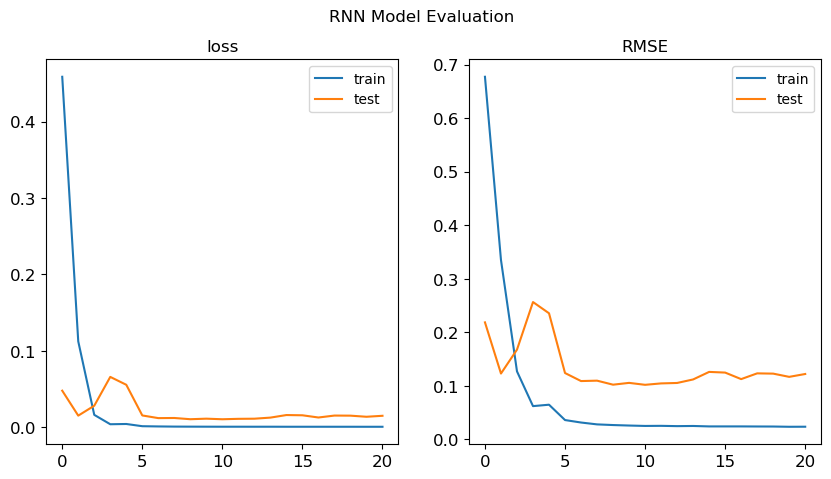

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='best')

ax2.set_title('RMSE')
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='best')

#### Predictions

In [33]:
#Predict:
y_pred_RNN = model.predict(test_x)

4/4 [==============================] - 0s 2ms/step


In [34]:
comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_y]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred_RNN).flatten()

In [35]:
comparison

,actual,predicted
0,87.360001,86.836655
1,83.570000,85.292107
2,82.849998,83.432709
3,81.620003,77.582314
4,84.300003,81.974548
...,...,...
96,122.230003,121.833145
97,118.529999,117.862595
98,116.860001,116.397148
99,117.809998,118.709274


In [36]:
performance = performance_metrics(comparison['actual'], comparison['predicted'], performance, "RNN with more layers")
performance

,model,mse
0,RNN with more layers,24.502139


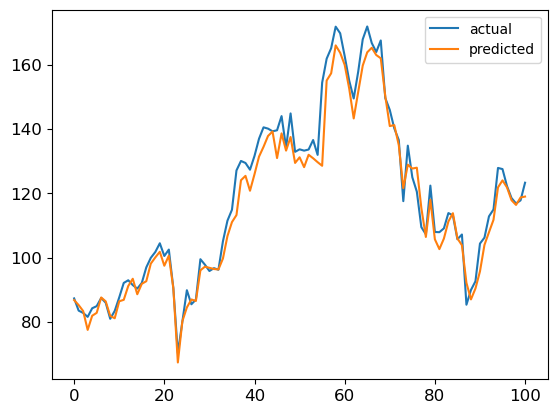

In [37]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

### 5.2 LSTM

In [38]:
model_LSTM = Sequential([
    LSTM(30, activation='tanh', return_sequences=False, input_shape=[n_steps, n_inputs]),
    #LSTM(30, activation='tanh', return_sequences=False),
    Dense(1, activation=None)
])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [39]:
np.random.seed(1)
tf.random.set_seed(1)
model_LSTM.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [40]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=20, verbose=1, mode='min')

history2 = model_LSTM.fit(
    train_x, 
    train_y, 
    epochs=800,
    validation_data=(test_x, test_y), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/800
8/8 [==============================] - 3s 65ms/step - loss: 0.5045 - root_mean_squared_error: 0.7103 - val_loss: 1.9727 - val_root_mean_squared_error: 1.4045
Epoch 2/800
8/8 [==============================] - 0s 9ms/step - loss: 0.3002 - root_mean_squared_error: 0.5479 - val_loss: 1.7344 - val_root_mean_squared_error: 1.3170
Epoch 3/800
8/8 [==============================] - 0s 13ms/step - loss: 0.1333 - root_mean_squared_error: 0.3651 - val_loss: 1.5230 - val_root_mean_squared_error: 1.2341
Epoch 4/800
8/8 [==============================] - 0s 17ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 1.3676 - val_root_mean_squared_error: 1.1695
Epoch 5/800
8/8 [==============================] - 0s 24ms/step - loss: 0.0203 - root_mean_squared_error: 0.1425 - val_loss: 1.2872 - val_root_mean_squared_error: 1.1345
Epoch 6/800
8/8 [==============================] - 0s 17ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 1.2525 - val_root_mean_squ

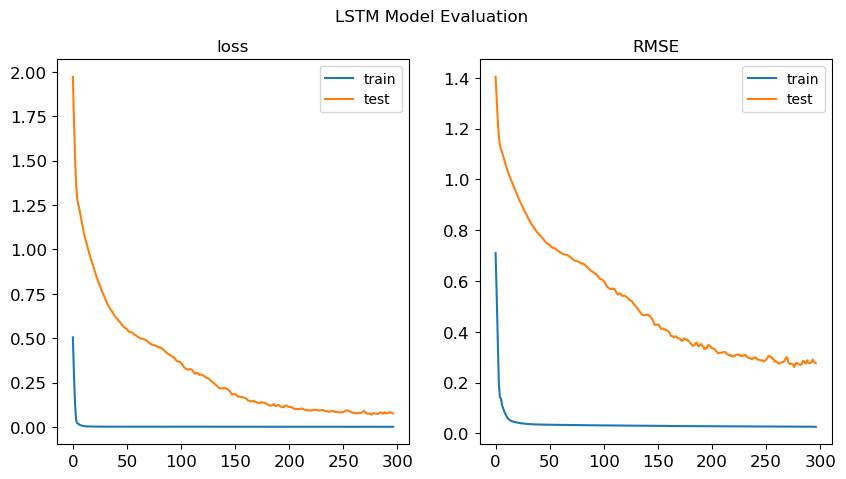

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
ax1.plot(history2.history['loss'])
ax1.plot(history2.history['val_loss'])
ax1.legend(['train', 'test'], loc='best')

ax2.set_title('RMSE')
ax2.plot(history2.history['root_mean_squared_error'])
ax2.plot(history2.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='best')

#### Predictions

In [42]:
#Predict:
y_pred_LSTM = model_LSTM.predict(test_x)

4/4 [==============================] - 0s 2ms/step


In [43]:
comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_y]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred_LSTM).flatten()

In [44]:
performance = performance_metrics(comparison['actual'], comparison['predicted'], performance, "LSTM")
performance

,model,mse
0,RNN with more layers,24.502139
0,LSTM,124.964353


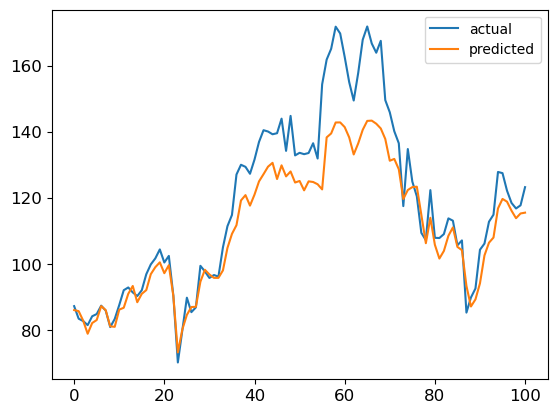

In [45]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

### 5.3 GRU

In [46]:
model_GRU = Sequential([
    GRU(30, return_sequences=False, input_shape=[n_steps, n_inputs]),
    # GRU(20, return_sequences=False),
    Dense(1, activation=None)
])
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30)                2970      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [47]:
np.random.seed(1)
tf.random.set_seed(1)
model_GRU.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [48]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=15, verbose=1, mode='min')

history3 = model_GRU.fit(
    train_x, 
    train_y, 
    epochs=600,
    validation_data=(test_x, test_y), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
8/8 [==============================] - 3s 59ms/step - loss: 0.4937 - root_mean_squared_error: 0.7026 - val_loss: 1.9465 - val_root_mean_squared_error: 1.3952
Epoch 2/600
8/8 [==============================] - 0s 8ms/step - loss: 0.2894 - root_mean_squared_error: 0.5379 - val_loss: 1.6117 - val_root_mean_squared_error: 1.2695
Epoch 3/600
8/8 [==============================] - 0s 8ms/step - loss: 0.1240 - root_mean_squared_error: 0.3521 - val_loss: 1.2993 - val_root_mean_squared_error: 1.1399
Epoch 4/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0454 - root_mean_squared_error: 0.2132 - val_loss: 1.0566 - val_root_mean_squared_error: 1.0279
Epoch 5/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.9189 - val_root_mean_squared_error: 0.9586
Epoch 6/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0260 - root_mean_squared_error: 0.1611 - val_loss: 0.8367 - val_root_mean_squared

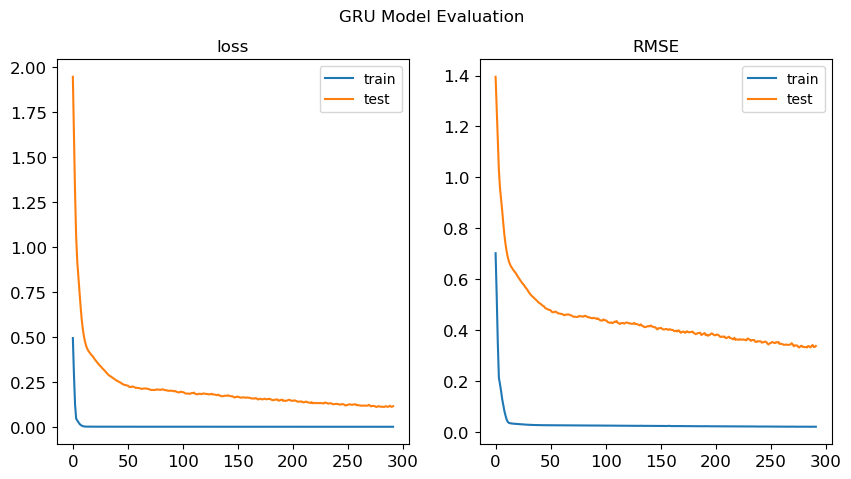

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
ax1.plot(history3.history['loss'])
ax1.plot(history3.history['val_loss'])
ax1.legend(['train', 'test'], loc='best')

ax2.set_title('RMSE')
ax2.plot(history3.history['root_mean_squared_error'])
ax2.plot(history3.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='best')

#### Predictions

In [50]:
#Predict:
y_pred_GRU = model_GRU.predict(test_x)
comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_y]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred_GRU).flatten()

4/4 [==============================] - 0s 2ms/step


In [51]:
performance = performance_metrics(comparison['actual'], comparison['predicted'], performance, "GRU")
performance

,model,mse
0,RNN with more layers,24.502139
0,LSTM,124.964353
0,GRU,187.904749


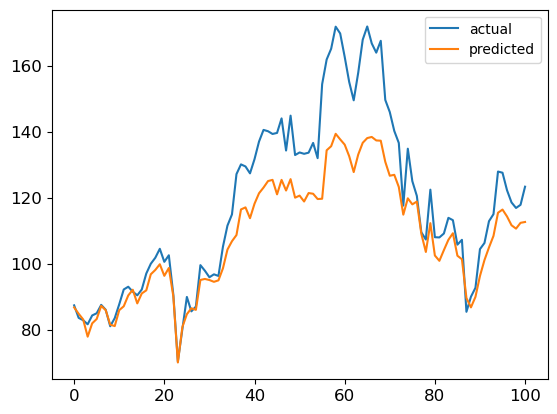

In [52]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

### 5.4 Conv1D

In [53]:
model_conv1D = Sequential([
    Conv1D(filters=15, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    SimpleRNN(20, activation = 'relu', return_sequences=True),
    SimpleRNN(20, activation = 'relu', return_sequences=False),
    Dense(1, activation=None)
])
model_conv1D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 15)             60        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 7, 20)             720       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


In [54]:
np.random.seed(1)
tf.random.set_seed(1)
model_conv1D.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [55]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history4 = model_conv1D.fit(
    train_x, 
    train_y, 
    epochs=600,
    validation_data=(test_x, test_y), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
8/8 [==============================] - 3s 45ms/step - loss: 0.5766 - root_mean_squared_error: 0.7593 - val_loss: 3.4514 - val_root_mean_squared_error: 1.8578
Epoch 2/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0949 - root_mean_squared_error: 0.3081 - val_loss: 2.0023 - val_root_mean_squared_error: 1.4150
Epoch 3/600
8/8 [==============================] - 0s 7ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 1.1827 - val_root_mean_squared_error: 1.0875
Epoch 4/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.7748 - val_root_mean_squared_error: 0.8802
Epoch 5/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.5050 - val_root_mean_squared_error: 0.7106
Epoch 6/600
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.3155 - val_root_mean_squared

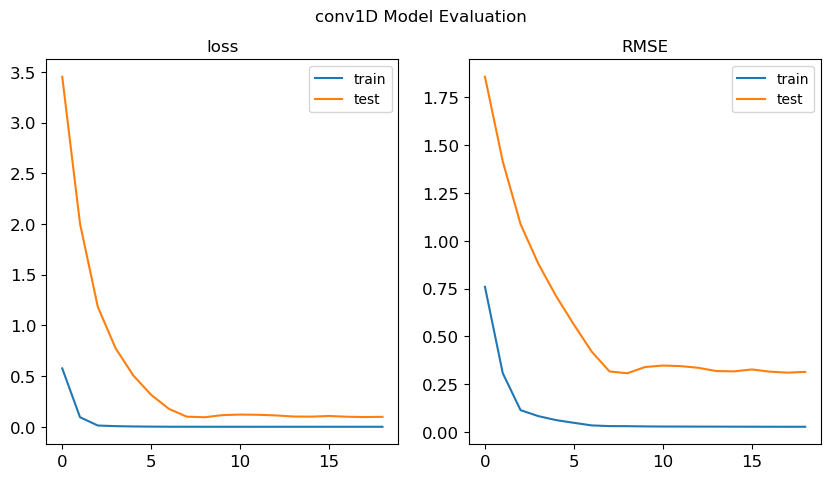

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('conv1D Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history4.history['loss'])
ax1.plot(history4.history['val_loss'])
ax1.legend(['train', 'test'], loc='best')

ax2.set_title('RMSE')
ax2.plot(history4.history['root_mean_squared_error'])
ax2.plot(history4.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='best')

#### Predictions

In [57]:
#Predict:
y_pred_conv1D = model_conv1D.predict(test_x)
comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_y]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred_conv1D).flatten()

4/4 [==============================] - 0s 2ms/step


In [58]:
performance = performance_metrics(comparison['actual'], comparison['predicted'], performance, "Conv1D")
performance

,model,mse
0,RNN with more layers,24.502139
0,LSTM,124.964353
0,GRU,187.904749
0,Conv1D,162.261143


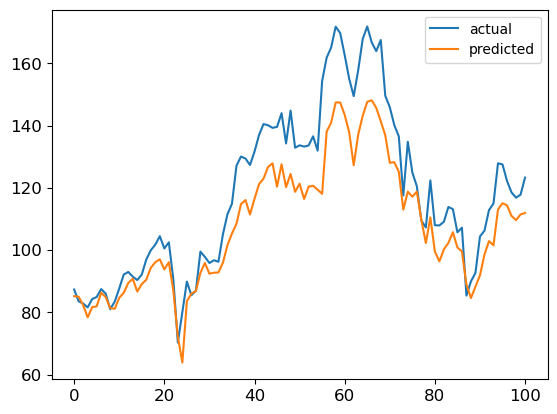

In [59]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## 6. Summary

In [60]:
performance.sort_values(by=['mse'])

,model,mse
0,RNN with more layers,24.502139
0,LSTM,124.964353
0,Conv1D,162.261143
0,GRU,187.904749


Of all the models, the one that performed the best was the RNN with two layers. I tried playing with deep networks but decided to keep just one layer for GRU and LSTM models to obtain a less high mse value.